# CheXpert : A Large Chest X-Ray Dataset and Competition

This competition launched by the Stanford ML group aims at finding a prediction model which could perform as well as radiologist to find different pathologies thanks to chest X-Ray. The Dataset available to train our model is composed of 223,414 chest radiographs of 65,240 patients.

<img src="https://github.com/gaetandi/cheXpert/blob/master/view1_frontal.jpg?raw=1" title="X-Ray image of the dataset" width = 320/>

The website of the competition:
https://stanfordmlgroup.github.io/competitions/chexpert/

[Publication](https://arxiv.org/pdf/1901.07031.pdf) : Irvin, Jeremy, et al. "CheXpert: A Large Chest Radiograph Dataset with Uncertainty Labels and Expert Comparison." arXiv preprint arXiv:1901.07031 (2019).

Our goal is first to reproduce main results obtained in the related paper, published in January 2019.

References:
https://github.com/gaetandi/cheXpert/blob/master/cheXpert_final.ipynb
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# fastai colab setup
# !curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
import os
import numpy as np
import time
import sys
import csv
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as tfunc
from torch.utils.data import Dataset
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import models

import PIL.Image
import torch.nn.functional as func

from sklearn.metrics.ranking import roc_auc_score
import sklearn.metrics as metrics
import random

use_gpu = torch.cuda.is_available()
use_gpu

True

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
import os

In [0]:
#os.chdir("/content/drive/My Drive/PyTorch_Hackathon_CheXpert/CheXpert-v1.0-small")
os.chdir("/content/drive/My Drive/Colab Notebooks/Challenge/data/CheXpert-v1.0-small")

In [0]:
!pwd

/content/drive/My Drive/Colab Notebooks/Challenge/data/CheXpert-v1.0-small


In [0]:
# Paths to the files with training, and validation sets.
# Each file contains pairs (path to image, output vector)
pathFileTrain = 'train50000.csv'
pathFileValid = 'valid.csv'

# Neural network parameters:
nnIsTrained = False                 #pre-trained using ImageNet
nnClassCount = 14                   #dimension of the output

# Training settings: batch size, maximum number of epochs
trBatchSize = 64
trMaxEpoch = 3

# Parameters related to image transforms: size of the down-scaled image, cropped image
imgtransResize = (255, 255)
imgtransCrop = 224

# Class names
class_names = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 
               'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 
               'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

## 1. Create a Dataset

In this first part, we create a loader able to load the data thanks to the csv files of the dataset.
This loader first load labels and paths to the different images.

It includes a pre-processing of labels to deal with uncertainty labels.
Indeed, four different labels exist:
-  **Blanks ('')**: the existence of the pathology is unknown
-  **Ones (1)**: the pathology is detected thanks to the image
-  **Zeros (0)**: the pathology can't be detected thanks to the image
-  **Uncertain (-1)**: the pathology may be detected.

In order to deal with uncertainty labels, different policies can be applied. The easiest ones consists in changing those **Uncertain** labels to *Blanks*, *Ones* or *Zeros*. This process is done thanks to the following class.

In [0]:
class CheXpertDataSet(Dataset):
    def __init__(self, image_list_file, transform=None, policy="ones", ttype="train"):
        """
        image_list_file: path to the file containing images with corresponding labels.
        transform: optional transform to be applied on a sample.
        Upolicy: name the policy with regard to the uncertain labels
        """
        x = []
        y = []

        with open(image_list_file, "r") as f:
            csvReader = csv.reader(f)
            next(csvReader, None)
            k=0
            for line in csvReader:
                k+=1
                image_name= line[0]
                label = line[5:]
                
                for i in range(14):
                    if label[i]:
                        a = float(label[i])
                        if a == 1:
                            label[i] = 1
                        elif a == -1:
                            if policy == "ones":
                                label[i] = 1
                            elif policy == "zeroes":
                                label[i] = 0
                            else:
                                label[i] = 0
                        else:
                            label[i] = 0
                    else:
                        label[i] = 0
                        
                x.append('/content/drive/My Drive/Colab Notebooks/Challenge/data/' + image_name)
                y.append(label)

        self.x = x
        self.y = y
        self.transform = transform

    def __getitem__(self, index):
        """Take the index of item and returns the image and its labels"""
        
        image_name = self.x[index]
        # image = Image.open(image_name).convert('RGB')
        image = PIL.Image.open(image_name).convert('RGB')
        label = self.y[index]
        if self.transform is not None:
            image = self.transform(image)
        return image, torch.LongTensor(label)

    def __len__(self):
        return len(self.x)

## 2. Create DataLoaders

First we define a transform model to resize all images and normalize them.

In [0]:
#TRANSFORM DATA

normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
transformList = []
transformList.append(transforms.Resize(imgtransResize))
transformList.append(transforms.RandomResizedCrop(imgtransCrop))
transformList.append(transforms.RandomHorizontalFlip())
transformList.append(transforms.ToTensor())
transformList.append(normalize)      
transformSequence = transforms.Compose(transformList)

In [0]:
class MyDataBunch(DataBunch):
  def __init__(self, train_dl:DataLoader, valid_dl:DataLoader, fix_dl:DataLoader=None, test_dl:Optional[DataLoader]=None,
                 device:torch.device=None, dl_tfms:Optional[Collection[Callable]]=None, path:PathOrStr='.',
                 collate_fn:Callable=data_collate, no_check:bool=False, c=2):
    DataBunch.__init__(self, train_dl, valid_dl, fix_dl=None, test_dl=None,
                 device=None, dl_tfms=None, path='.',
                 collate_fn=data_collate, no_check=False)
    
    self.c = c
  
  @classmethod
  def create(cls, train_ds:Dataset, valid_ds:Dataset, test_ds:Optional[Dataset]=None, path:PathOrStr='.', bs:int=64,
               val_bs:int=None, num_workers:int=defaults.cpus, dl_tfms:Optional[Collection[Callable]]=None,
               device:torch.device=None, collate_fn:Callable=data_collate, no_check:bool=False, c=2, **dl_kwargs)->'DataBunch':
        "Create a `DataBunch` from `train_ds`, `valid_ds` and maybe `test_ds` with a batch size of `bs`. Passes `**dl_kwargs` to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        dls = [DataLoader(d, b, shuffle=s, drop_last=s, num_workers=num_workers, **dl_kwargs) for d,b,s in
               zip(datasets, (bs,val_bs,val_bs,val_bs), (True,False,False,False)) if d is not None]
        return cls(*dls, path=path, device=device, dl_tfms=dl_tfms, collate_fn=collate_fn, no_check=no_check, c=c)

Then we build train, validation and test data loaders. 

In [0]:
#LOAD DATASET

train_ds = CheXpertDataSet(pathFileTrain ,transformSequence, policy="ones", ttype="train")
# test_ds, train_ds = random_split(train_ds, [500, len(train_ds) - 500])
valid_ds = CheXpertDataSet(pathFileValid, transformSequence, ttype="valid")   

# Create dataloaders
dataloaderTrain = DataLoader(dataset=train_ds, batch_size=trBatchSize, shuffle=True)
dataloaderValid = DataLoader(dataset=valid_ds, batch_size=trBatchSize, shuffle=False)
# dataloaderTest = DataLoader(dataset=test_ds, batch_size=trBatchSize, shuffle=False)

# Create databunch
data = MyDataBunch.create(train_ds=train_ds, valid_ds=valid_ds, bs=trBatchSize, c=nnClassCount)
# data = MyDataBunch.create(train_ds=train_ds, valid_ds=valid_ds, test_ds=test_ds, bs=trBatchSize, c=nnClassCount)

In [0]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [0]:
images, labels = next(iter(dataloaderValid))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


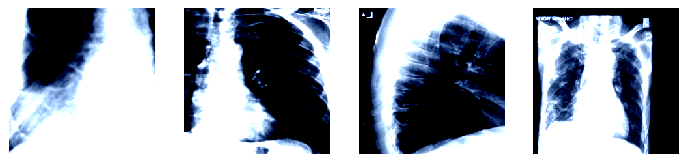

In [0]:
fig, axes = plt.subplots(figsize=(12,9), ncols=4)
for ii in range(4):
  ax = axes[ii]
  imshow(images[ii], ax=ax, normalize=False)

## 3. Create Architecture and Train Model

Create an architecture of resnet50, find the best learning rate, and train the model using best slice learning rates.

In [0]:
# fastai

In [0]:
arch = models.resnet50
# arch = models.densenet121

In [0]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])
learn.loss_func = BCEWithLogitsFlat()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:00<00:00, 105529550.11it/s]


In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


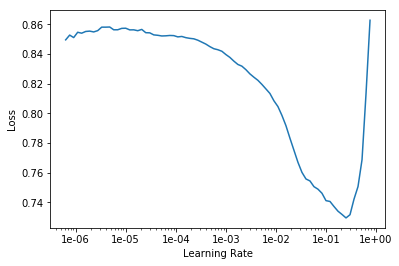

In [0]:
learn.recorder.plot()

In [0]:
lr = 0.03

In [0]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


In [0]:
# Save model before fine tuning
learn.save('stage-1-rn50')

In [0]:
# Fine tune model
learn.unfreeze()

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.378650,0.450442,0.788156,0.575232,03:06
1,0.383189,0.495613,0.770146,0.552178,03:07
2,0.376022,0.369219,0.772283,0.604469,03:07
3,0.368444,0.371852,0.774725,0.597337,03:08
4,0.365860,0.377561,0.784799,0.594255,03:02


In [0]:
# pytorch pre-trained model

In [0]:
model = models.resnet50(pretrained=True)
model

In [0]:
# Modify resnet50 for our training dataset
for param in model.parameters():
  param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                         ('fc', nn.Linear(1024, 256)),
                         ('relu', nn.ReLU()),
                         ('dropout', nn.Dropout(0.2)),
                         ('fc2', nn.Linear(256, nnClassCount))
                         ]))

model.classifier = classifier

In [0]:
# Training on GPU
device = torch.device("cuda" if torch.cuda.is_available else "cpu")

criterion = nn.MultiLabelSoftMarginLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-5)

model.to(device)

In [0]:
epochs = 1
for epoch in range(epochs):
  losses = []
  for inputs, labels in dataloaderTrain:
      # Move input and label tensors to the default device
      inputs, labels = inputs.to(device), labels.to(device)
      labels.long()

      optimizer.zero_grad()
        
      logps = model.forward(inputs)
      loss = criterion(logps, labels)
      loss.backward()
      optimizer.step()

      losses.append(loss.data.mean())
  print('[%d/%d] Loss: %.3f' % (epoch+1, epochs, np.mean(losses)))